In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt

PATH = 'data/'
EMB = 'embeddings/'
EVAL = 'evaluation/'

In [2]:
with open(EMB+'data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
# 2000 words -> 10 decades -> 300 embedding size
emb = np.array(data['E'])
emb.shape

(2000, 10, 300)

# Aligning Historical Embeddings

In [4]:
rotation_arr = [emb[:,0,:]]
for i in range(1,10):
    ret = orthogonal_procrustes(emb[:,i,:], rotation_arr[-1])
    rotation_arr.append(emb[:,i,:] @ ret[0])

In [5]:
emb = np.stack(rotation_arr)
emb = np.einsum('ijk->jki', emb)
emb.shape

(2000, 300, 10)

# Measuring Degree of Semantic Change

## Method 1 - STD

In [6]:
emb_std = np.array([emb[i].std(1).mean() for i in range(emb.shape[0])])
emb_std.shape

(2000,)

## Method 2 - Linear Regression

In [7]:
x = np.arange(10)/10
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [8]:
lin_emb = np.array(
    [[np.polyfit(x, emb[i][y], 1)[0]
      for y in range(emb.shape[1])]
     for i in range(emb.shape[0])])

In [9]:
lin_emb_sum = np.abs(lin_emb).sum(1)
lin_emb_sum.shape

(2000,)

## Method 3 - Cosine Distance

In [10]:
weights = np.arange(1,10)/10
weights

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [11]:
cos_dist_emb = []
for i in range(2000):
    val = np.array([
        distance.cosine(emb[i,:,0], emb[i,:,y])
        for y in range(1,10)]
        )
    val[np.isnan(val)] = 0
    cos_dist_emb.append(val.dot(weights))

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## Intercorrelation among methods

In [12]:
semantic_scores = pd.DataFrame(
    zip(data['w'],emb_std,lin_emb_sum,cos_dist_emb),
    columns=['words','std','lin_reg','cos_dist']
)
semantic_scores.corr()

,std,lin_reg,cos_dist
std,1.000000,0.847127,0.864748
lin_reg,0.847127,1.000000,0.846986
cos_dist,0.864748,0.846986,1.000000


## Top Words

In [22]:
from collections import defaultdict

top_k = 200
dct = {
    'most':{'std':None,'lin_reg':None,'cos_dist':None},
    'least':{'std':None,'lin_reg':None,'cos_dist':None}
      }
for col in dct['most'].keys():
    arr = semantic_scores.sort_values(by=col)['words'].values
    dct['least'][col] = arr[:top_k]
    dct['most'][col] = arr[-1*top_k:]

In [23]:
top_words = pd.concat([pd.DataFrame(dct['least']),pd.DataFrame(dct['most'])], axis=1)
columns=[(val,sub_val) for val in dct for sub_val in dct[val]]
top_words.columns=pd.MultiIndex.from_tuples(columns)
top_words.head(20)

most                              least                            
            std    lin_reg    cos_dist         std      lin_reg       cos_dist
0         april      april  techniques        drug  achievement         edward
1      november   november          ml        bone    telephone          entry
2     september   february      mcgraw         eve        grain        address
3      february       wife      skills      strain    societies        tension
4       january    january   september  enterprise        fault          focus
5      december  september    november    virginia         fund          index
6       october        god       april   attitudes    household        fortune
7         miles    october    february    stranger          job      mechanism
8          june       june     january          cm      concern           mark
9        months    evening     october     network        shock          logic
10       duties     months        june        duke        track  communication
11   university   december      months    membrane        sugar      democracy
12         july       july       miles   elizabeth          fee    engineering
13      evening     amount    december    planning        smith           sets
14       august    husband        july      breath       skills          shock
15    buildings      miles       names       china        trust       payments
16       amount     father      duties      stones            v          frame
17          god    brother       years       frame       credit      alexander
18  temperature     period     evening  background     exposure        georgia
19      dollars  direction         god           n       regime        answers

## Supervised Evaluation

In [15]:
changed_words_df = pd.read_csv(EVAL+'ChangedWords.csv')
changed_words = changed_words_df['Word'].values
changed_words_df.head(3)

,Source,Word
0,Baroni et.al 2011,card
1,Baroni et.al 2011,sleep
2,Baroni et.al 2011,parent


In [16]:
eval_dfs = {}
for i in range(1,4):
    eval_dfs[f'evaluator_{i}'] = pd.read_csv(EVAL+f'/20WordsEvaluator{i}.csv')
words_filter = sum([eval_dfs[df]['CHANGED OR NOT'] for df in eval_dfs]) >= 1.

evaluator_words = eval_dfs['evaluator_1'].loc[words_filter, 'WORD'].values

In [17]:
all_eval_words = np.hstack([changed_words, evaluator_words,['meat', 'girl']])
filtered_eval_words = [w for w in all_eval_words if w in semantic_scores['words'].values]

In [18]:
for col in top_words['most'].columns:
    val = len(set(top_words['most'][col])&set(filtered_eval_words))/len(filtered_eval_words)
    print(f"Recall@{top_k} - {col}: {val:.4f}")

Recall@200 - std: 0.0769
Recall@200 - lin_reg: 0.2308
Recall@200 - cos_dist: 0.1538


# Key Points Detection (Linear Regression)

In [19]:
lin_df = semantic_scores.sort_values('lin_reg',ascending=False)['words'].head(3)
lin_keys = list(lin_df.keys())

<ipython-input-20-904a0a709bea>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(ax, xticklabels=data['d'])


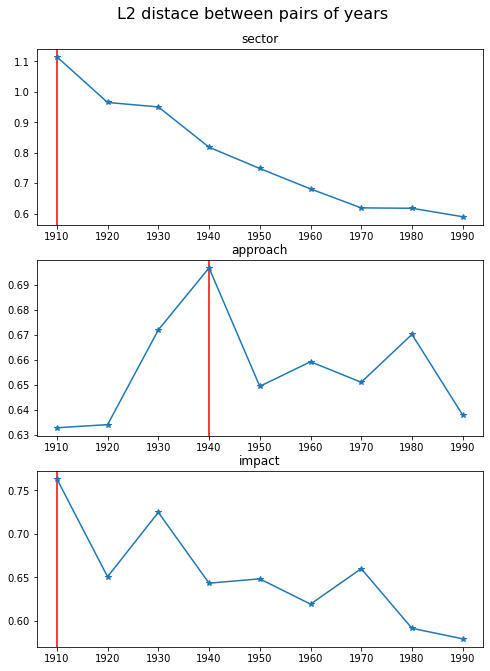

In [20]:
fig, ax = plt.subplots(len(lin_keys), figsize=(8,11))
plt.setp(ax, xticklabels=data['d'])
for ind,k in enumerate(lin_keys):
    l2 = [np.linalg.norm(emb[k][:,i] - emb[k][:,i+1]) for i in range(9)]
    ax[ind].axvline(x=np.argmax(l2),color='red')
    ax[ind].plot(l2, marker='*')
    ax[ind].set_title(data['w'][k])
fig.suptitle('L2 distace between pairs of years',y=0.933, fontsize=16);